In [1]:
import numpy as np
import pandas as pd
import random
import time
import math
import os
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter as sg_filter
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import init
from dateutil import parser
from pathlib import Path
import json 
import shutil

from wattile.data_reading import read_dataset_from_file
from wattile.buildings_processing import correct_predictor_columns, correct_timestamps, rolling_stats, input_data_split
from wattile.time_processing import add_processed_time_columns
from wattile.models.liangs_model import main as liangs_model
PROJECT_DIRECTORY = Path().resolve().parent.parent

/Users/heslinge/Library/Caches/pypoetry/virtualenvs/wattile-1xllfzwh-py3.8/lib/python3.8/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


### reading configs

In [2]:
"""
For this example, we will be using the default configs.
Check out the docs for an explaination of each config.
"""
##################################################################################
# choose the configs file to use as an input
##################################################################################
# # main configs file
# with open(PROJECT_DIRECTORY / "wattile" / "configs" / "configs.json", "r") as f:
#     configs = json.load(f)
##################################################################################
# code testing configs file
with open(PROJECT_DIRECTORY / "tests" / "fixtures" / "test_configs.json", "r") as f:
    configs = json.load(f)
##################################################################################

exp_dir = PROJECT_DIRECTORY / "notebooks" / "exp_dir"
if exp_dir.exists():
    shutil.rmtree(exp_dir)
exp_dir.mkdir()

configs["exp_dir"] = str(exp_dir)
configs["num_epochs"] = 10
configs["data_dir"] = str(PROJECT_DIRECTORY / "tests" / "data")

configs

{'building': 'Synthetic Site',
 'target_var': 'Synthetic Site Electricity Main Total Power',
 'start_time': '2018-01-01T00:00:00-07:00',
 'end_time': '2022-01-01T00:00:00-07:00',
 'data_time_interval_mins': 1,
 'predictor_columns': ['Synthetic Weather Station Dew Point Temperature',
  'Synthetic Weather Station Diffuse Horizontal Irradiance',
  'Synthetic Weather Station Direct Normal Irradiance',
  'Synthetic Weather Station Dry Bulb Temperature',
  'Synthetic Weather Station Global Horizontal Irradiance',
  'Synthetic Weather Station Relative Humidity',
  'Synthetic Weather Station Wind Speed'],
 'arch_version': 4,
 'exp_id': 'Debugging_for_rolling_stats',
 'arch_type': 'RNN',
 'arch_type_variant': 'lstm',
 'transformation_method': 'minmaxscale',
 'train_batch_size': 5,
 'val_batch_size': 1,
 'convert_csvs': False,
 'exp_dir': '/Users/heslinge/Repos/Wattile/notebooks/exp_dir',
 'data_dir': '/Users/heslinge/Repos/Wattile/tests/data',
 'resample_freq': 15,
 'sequence_freq_min': 15,
 's

### override config if necessary

In [3]:
# configs["feat_stats"]["window_width"] = '15min'
# configs["feat_stats"]["window_increment"] = '15min'

### reading data

In [4]:
site = configs['building']

In [5]:
data = read_dataset_from_file(configs)
data

,Synthetic Weather Station Dew Point Temperature,Synthetic Weather Station Diffuse Horizontal Irradiance,Synthetic Weather Station Direct Normal Irradiance,Synthetic Weather Station Dry Bulb Temperature,Synthetic Weather Station Global Horizontal Irradiance,Synthetic Weather Station Relative Humidity,Synthetic Weather Station Wind Speed,Synthetic Site Electricity Main Total Power
Timestamp,,,,,,,,
2021-12-01 07:00:00+00:00,15.413733,-1.525850,-0.005199,56.408001,-1.810825,17.930000,10.457981,104.800003
2021-12-01 07:01:00+00:00,15.183906,-1.496226,0.207964,56.174000,-1.841866,17.879999,11.265539,96.650002
2021-12-01 07:02:00+00:00,14.891221,-1.441191,0.457520,55.886002,-1.873579,17.809999,12.777752,96.199997
2021-12-01 07:03:00+00:00,14.836164,-1.371754,0.473117,55.796001,-1.860084,17.820000,12.694983,95.599998
2021-12-01 07:04:00+00:00,14.782966,-1.317349,0.545903,55.723999,-1.843271,17.820000,11.632407,100.650002
...,...,...,...,...,...,...,...,...
2021-12-08 06:55:00+00:00,11.210565,-1.487212,-0.254757,42.285198,-1.814939,24.680000,0.000000,109.664803
2021-12-08 06:56:00+00:00,11.190062,-1.445182,-0.233960,41.997200,-1.852901,24.930000,0.000000,107.002800
2021-12-08 06:57:00+00:00,11.223961,-1.396302,-0.145575,41.669601,-1.841248,25.290001,3.545647,106.480400


### feature extraction

In [6]:
# assert we have the correct columns and order them
data = correct_predictor_columns(configs, data)

# sort and trim data specified time period
data = correct_timestamps(configs, data)

# Add time-based features
data = add_processed_time_columns(data, configs)

# Add statistics features
data = rolling_stats(data, configs)

data

,Synthetic Weather Station Dew Point Temperature_min,Synthetic Weather Station Diffuse Horizontal Irradiance_min,Synthetic Weather Station Direct Normal Irradiance_min,Synthetic Weather Station Dry Bulb Temperature_min,Synthetic Weather Station Global Horizontal Irradiance_min,Synthetic Weather Station Relative Humidity_min,Synthetic Weather Station Wind Speed_min,sin_HOD_min,cos_HOD_min,DOW_binary_reg_0_min,...,DOW_binary_reg_0_mean,DOW_binary_reg_1_mean,DOW_binary_reg_2_mean,DOW_binary_reg_3_mean,DOW_binary_reg_4_mean,DOW_binary_reg_5_mean,DOW_binary_reg_6_mean,sin_MOY_mean,cos_MOY_mean,Synthetic Site Electricity Main Total Power
Timestamp,,,,,,,,,,,,,,,,,,,,,
2021-12-01 07:00:00+00:00,15.413733,-1.525850,-0.005199,56.408001,-1.810825,17.930000,10.457981,0.965926,-2.588190e-01,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.493776,0.869589,104.800003
2021-12-01 07:15:00+00:00,14.782966,-1.496226,-0.540707,55.112000,-1.873579,17.809999,9.395406,0.946930,-3.214395e-01,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.493776,0.869589,103.650002
2021-12-01 07:30:00+00:00,15.474850,-1.379412,-1.741706,54.608002,-1.918852,18.690001,8.612455,0.923880,-3.826834e-01,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.493776,0.869589,98.050003
2021-12-01 07:45:00+00:00,16.614972,-1.642929,-2.147240,53.743999,-2.029242,19.320000,4.503084,0.896873,-4.422887e-01,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.493776,0.869589,98.349998
2021-12-01 08:00:00+00:00,16.413343,-1.480409,-0.426325,52.807999,-1.958610,21.090000,3.746977,0.866025,-5.000000e-01,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.493776,0.869589,102.949997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-08 06:00:00+00:00,11.961447,-1.673728,-1.211398,41.388802,-1.909901,25.160000,0.000000,0.998135,-1.608123e-16,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.385663,0.922640,104.668396
2021-12-08 06:15:00+00:00,11.008480,-1.489343,-0.504314,41.646198,-1.936419,24.240000,0.000000,0.997859,-6.540313e-02,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.385663,0.922640,102.709602
2021-12-08 06:30:00+00:00,10.851442,-1.571301,-0.655083,42.024200,-1.834018,23.760000,0.000000,0.991445,-1.305262e-01,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.385663,0.922640,105.972198


In [7]:
for loss_function_qs in [0.05, 0.25, 0.50, 0.75, 0.95]: #[0.50]:#[0.05, 0.50, 0.95]:
    print(f"Processing loss function alpha: {loss_function_qs}")
    s, s2, mape_s, mae_s, mae, mape, total_mins, train_loss, test_loss, for_plotting, MU, STD = liangs_model(
        seed=42, 
        cuda=False,
        cell_type='lstm', 
        attention_model='BA', 
        la_method='none',
        window_source_size=12, # same as T in the dimension figure.
        window_target_size=3,  # same as N in the dimension figure. And S = int(total rows in data / N)
        epochs=configs["num_epochs"],
        batch_size=256, 
        hs=64, # use hidden nodes from our existing configs?
        save_model=False, 
        loss_function_qs = loss_function_qs, 
        normalization = False,
        data=data,
        configs=configs
    )

Processing loss function alpha: 0.05
Generating training and test data...
Created 513 train samples and 19 test samples
MODEL ARCHITECTURE IS: 
S2S_BA_Model(
  (Ecell): LSTMCell(55, 64)
  (Dcell): LSTMCell(65, 64)
  (Wattn_energies): Linear(in_features=128, out_features=64, bias=True)
  (Wusage): Linear(in_features=64, out_features=1, bias=True)
  (Wout): Linear(in_features=129, out_features=64, bias=True)
)

Model parameters are on cuda: False

Starting training...
Epoch 1
	TRAINING: 15.55763864517212 total train USAGE loss.

	TESTING: 5.343607425689697 total test USAGE loss
	TESTING:

	Sample of prediction:
		 TARGET: [111.27535  114.54542  113.212006]
		   PRED: [1.568447  1.912101  2.0002387]


TIME OF ONE EPOCH: 0.16829395294189453 seconds and 0.0028048992156982423 minutes
Epoch 2
	TRAINING: 15.363085269927979 total train USAGE loss.

	TESTING: 5.274266242980957 total test USAGE loss
	TESTING:

	Sample of prediction:
		 TARGET: [111.27535  114.54542  113.212006]
		   PRED: [2.4710

	TRAINING: 155.5763816833496 total train USAGE loss.

	TESTING: 53.436031341552734 total test USAGE loss
	TESTING:

	Sample of prediction:
		 TARGET: [111.27535  114.54542  113.212006]
		   PRED: [1.5685301 1.9122349 2.0004194]


TIME OF ONE EPOCH: 0.14927411079406738 seconds and 0.0024879018465677897 minutes
Epoch 2
	TRAINING: 153.63076400756836 total train USAGE loss.

	TESTING: 52.7425651550293 total test USAGE loss
	TESTING:

	Sample of prediction:
		 TARGET: [111.27535  114.54542  113.212006]
		   PRED: [2.4714994 3.0687733 3.2463856]


TIME OF ONE EPOCH: 0.15927505493164062 seconds and 0.002654584248860677 minutes
Epoch 3
	TRAINING: 151.46411895751953 total train USAGE loss.

	TESTING: 51.966636657714844 total test USAGE loss
	TESTING:

	Sample of prediction:
		 TARGET: [111.27535  114.54542  113.212006]
		   PRED: [3.5671952 4.5082693 4.8271694]


TIME OF ONE EPOCH: 0.15674996376037598 seconds and 0.0026124993960062663 minutes
Epoch 4
	TRAINING: 148.92265701293945 total train US

	TRAINING: 295.59513092041016 total train USAGE loss.

	TESTING: 101.52845764160156 total test USAGE loss
	TESTING:

	Sample of prediction:
		 TARGET: [111.27535  114.54542  113.212006]
		   PRED: [1.5685356 1.9122465 2.000436 ]


TIME OF ONE EPOCH: 0.14231014251708984 seconds and 0.0023718357086181642 minutes
Epoch 2
	TRAINING: 291.8984375 total train USAGE loss.

	TESTING: 100.21086120605469 total test USAGE loss
	TESTING:

	Sample of prediction:
		 TARGET: [111.27535  114.54542  113.212006]
		   PRED: [2.4715424 3.0688214 3.246451 ]


TIME OF ONE EPOCH: 0.1533498764038086 seconds and 0.0025558312733968097 minutes
Epoch 3
	TRAINING: 287.7817916870117 total train USAGE loss.

	TESTING: 98.7365951538086 total test USAGE loss
	TESTING:

	Sample of prediction:
		 TARGET: [111.27535  114.54542  113.212006]
		   PRED: [3.56723   4.5083265 4.8272486]


TIME OF ONE EPOCH: 0.15195274353027344 seconds and 0.0025325457255045572 minutes
Epoch 4
	TRAINING: 282.95296478271484 total train USAGE los

### visualization

In [8]:
q95 = pd.read_csv(f'results/{site}/q0.95.csv')
q75 = pd.read_csv(f'results/{site}/q0.75.csv')
q50 = pd.read_csv(f'results/{site}/q0.5.csv')
q25 = pd.read_csv(f'results/{site}/q0.25.csv')
q05 = pd.read_csv(f'results/{site}/q0.05.csv')
actual = pd.read_csv(f'results/{site}/actual.csv')

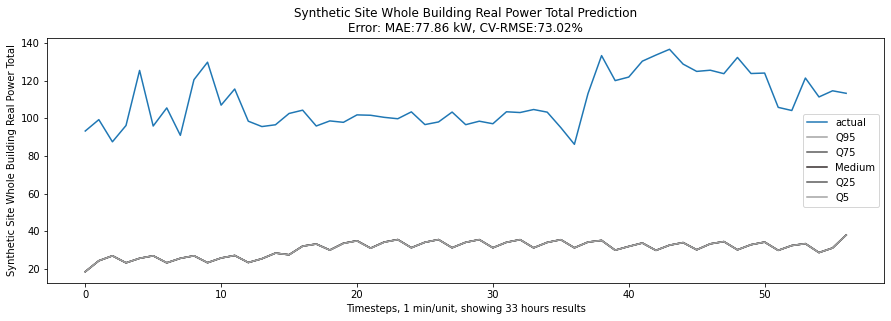

In [9]:
plt.figure(figsize=(15, 4.5))

# calculating error
y_actual = actual
y_predicted = q50.values.flatten()
MSE = mean_squared_error(y_actual, y_predicted)
RMSE = MSE**0.5
CV_RMSE = RMSE/y_actual.mean().values[0]
mae = mean_absolute_error(y_actual, y_predicted)

plt.title(f'{site} Whole Building Real Power Total Prediction\nError: MAE:{mae:.2f} kW, CV-RMSE:{CV_RMSE*100:.2f}%')

plt.plot(actual, label = 'actual')
plt.plot(sg_filter(q95.values.flatten(),5,2), label = 'Q95', color = '#a2a2a2')
plt.plot(sg_filter(q75.values.flatten(),5,2), label = 'Q75', color = '#5b5b5b')
plt.plot(sg_filter(q50.values.flatten(),5,2), label = 'Medium', color = '#322b2b')
plt.plot(sg_filter(q25.values.flatten(),5,2), label = 'Q25', color = '#5b5b5b')
plt.plot(sg_filter(q05.values.flatten(),5,2), label = 'Q5', color = '#a2a2a2')


plt.legend()

# plt.ylim(20,40)
# n=0
# plt.xlim(1000, 1720)

plt.ylabel(f'{site} Whole Building Real Power Total')
plt.xlabel('Timesteps, 1 min/unit, showing 33 hours results')

plt.show()